In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.stem import PorterStemmer #normalize word form
from nltk.probability import FreqDist #frequency word count
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords #stop words
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.probability import FreqDist 
import matplotlib.pyplot as plt
%matplotlib inline
import string
import re
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/fasttext-crawl-300d-2m/crawl-300d-2M.vec
/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec
/kaggle/input/correct-submission/correct_submission.csv
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin


In [2]:
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

# The functions used for text preprosessing

In [3]:
def text_cleaning_hyperlink(text,rep):
    
    #remove hyper link
    return re.sub(r"http\S+","{}".format(rep),text) #remove hyperlink

In [4]:
# REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
# REPLACE_BY_SPACE_RE.sub(' ', text)

In [5]:
# remove punctuation marks
import string
def text_cleaning_punctuation(text):
    
    translator =  str.maketrans(string.punctuation, ' '*len(string.punctuation)) #remove punctuation
    
    
    return text.translate(translator)

In [6]:
# text_cleaning_punctuation('!text*o')

In [7]:
# clean stopwords

def text_cleaning_stopwords(text):
    
    stop_words = set(stopwords.words('english'))
    
    word_token = word_tokenize(text)
    
    filtered_sentence = [w for w in word_token if not w in stop_words]
    
    return ' '.join(filtered_sentence) #return string of no stopwords


In [8]:
# convert all letters into lowercase ones

def text_cleaning_lowercase(text):
    
    return text.lower()

In [9]:
def text_extract(text_lst):
    txt = []
    for i,x in enumerate(text_lst):
        
        for j,p in enumerate(x):
            
            txt.append(p)
    
    return txt
    

In [10]:
# remove digits from the text

def remove_digits(txt):
    
    no_digits = ''.join(i for i in txt if not i.isdigit())
    
    return no_digits

In [11]:
from nltk import pos_tag, word_tokenize
ps = PorterStemmer()
wnl = WordNetLemmatizer()


def word_lemmatizer_1(sentence):
    
    n_sentence = []
    
    for word, tag in pos_tag(word_tokenize(sentence)):
    
        wntag = tag[0].lower()
    
        if wntag in ['a', 'r', 'n', 'v']:
        
            wntag = wntag
        else:
        
            wntag = None
        
        if not wntag:
            
            lemma = wnl.lemmatize(word)
        
        else:
            
            lemma = wnl.lemmatize(word,wntag)
        
        n_sentence.append(lemma)
        
    
    n_s = ' '.join(n_sentence)
    
    return n_s


In [12]:
from nltk import pos_tag, word_tokenize
ps = PorterStemmer()
wnl = WordNetLemmatizer()


def word_lemmatizer_2(sentence):
    
    n_sentence = []
    
    for word, tag in pos_tag(word_tokenize(sentence)):
    
        wntag = tag[0].lower()
    
        if wntag in ['a', 'r', 'n']:
        
            wntag = wntag
        else:
        
            wntag = None
        
        if not wntag:
            
            lemma = wnl.lemmatize(word)
        
        else:
            
            lemma = wnl.lemmatize(word,wntag)
        
        n_sentence.append(lemma)
        
    
    n_s = ' '.join(n_sentence)
    
    return n_s

In [13]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#ref:https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings

In [14]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/fasttext-wikinews/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [15]:
# from gensim.models import KeyedVectors
# #check the intersection google embeding 
# news_path = "../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin"
# embeddings_index_google = KeyedVectors.load_word2vec_format(news_path, binary=True)

In [16]:
glove = '../input/glove840b300dtxt/glove.840B.300d.txt'
# wiki_news = '../input/fasttext-wikinews/wiki-news-300d-1M.vec'

In [17]:
embedding_index_glove = load_embed(glove) #loading glove


In [18]:
# embedding_index_fasttext = load_embed(wiki_news) #loading fasttext

In [19]:
#vocabulary without cleaning process
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
sentences = train["text"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 7613/7613 [00:00<00:00, 137881.88it/s]

{'Our': 25, 'Deeds': 1, 'are': 345, 'the': 2575, 'Reason': 5}


In [20]:
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [21]:
oov_glove = check_coverage(vocab,embedding_index_glove)#without cleanning

100%|██████████| 31924/31924 [00:00<00:00, 515847.15it/s]

Found embeddings for 52.06% of vocab
Found embeddings for  82.68% of all text


In [22]:
#our methord to clean the words

In [23]:
#Clean the text

In [24]:
train['text_clean'] = train.text.apply(lambda x: text_cleaning_stopwords(text_cleaning_punctuation(text_cleaning_hyperlink(remove_digits(x),'http'))))
train['text_clean'] = train['text_clean'].apply(lambda x: list(set(x.split(' '))))
train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join(x))

In [25]:
sentences_clean = train['text_clean'].apply(lambda x: x.split())
vocab_clean = build_vocab(sentences_clean)

100%|██████████| 7613/7613 [00:00<00:00, 188378.21it/s]


In [26]:
oov_text_clean_glove = check_coverage(vocab_clean,embedding_index_glove) #better performance using our cleanning #after applying cleanning without lemmatizer

100%|██████████| 20730/20730 [00:00<00:00, 560036.60it/s]

Found embeddings for 81.77% of vocab
Found embeddings for  94.02% of all text


In [27]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train['text_clean'],train.target, test_size=0.3)

In [28]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
## Tokenize the sentences
max_features = 2000
maxlen = max([len(i) for i in sentences_clean])
embed_size = 300

tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X_train_1))

X_train_token = tokenizer.texts_to_sequences(X_train_1)
X_test_token = tokenizer.texts_to_sequences(X_test_1)

## Pad the sentences 
X_train_sequence = pad_sequences(X_train_token, maxlen=maxlen)
X_test_sequence = pad_sequences(X_test_token, maxlen=maxlen)

Using TensorFlow backend.


In [29]:
word_index = tokenizer.word_index
max_features = len(word_index)+1

def load_embedding(word_index,embeddings_index):
#     EMBEDDING_FILE = '../input/glove840b300dtxt/glove.840B.300d.txt''
#     def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
#     embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

# ref: https://www.kaggle.com/gmhost/gru-capsule

In [30]:
embedding_matrix_glove = load_embedding(word_index,embedding_index_glove)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
# embedding_matrix_google = load_embedding(word_index,embeddings_index_google)

In [32]:
# embedding_matrix_google = load_glove(word_index,embeddings_index_google)

In [33]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding,Dropout
from keras.regularizers import l2
 
model_2 = Sequential()
model_2.add(Embedding(max_features,
                    embed_size,  # Embedding size
                    weights=[embedding_matrix_glove],
                    input_length=maxlen,
                    trainable=False))
#model_2.add(LSTM(100))
model_2.add(LSTM(32, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model_2.add(Dropout(0.5))
model_2.add(Dense(units=300, activation='sigmoid'))#nodes matter
model_2.add(Dense(units=100, activation='sigmoid'))#nodes matter
model_2.add(Dense(units=1, activation='sigmoid'))
 
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_2.summary())
 
history =  model_2.fit(X_train_sequence, y_train_1, epochs=20, validation_split=0.3,batch_size=200, verbose=1)#batch size matter
 
scores = model_2.evaluate(X_test_sequence, y_test_1, verbose=1)
print("Accuracy:", scores[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 300)           3987600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9900      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 4,070,325
Trainable params: 82,725
Non-trainable params: 3,987,600
_______________________________________

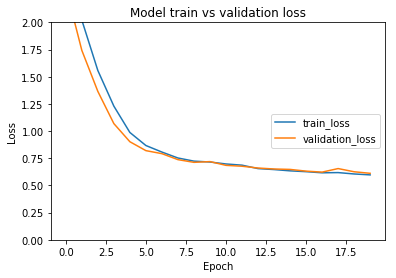

In [34]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Model train vs validation loss')
pyplot.ylabel('Loss')
pyplot.xlabel('Epoch')
pyplot.legend(['train_loss', 'validation_loss'], loc='center right')
pyplot.ylim(0.00, 2.00)
#pyplot.xlim(0,10)
pyplot.show()

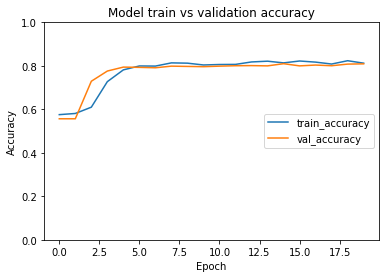

In [35]:
pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Model train vs validation accuracy')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epoch')
pyplot.legend(['train_accuracy', 'val_accuracy'], loc='center right')
pyplot.ylim(0.00, 1.00)
#pyplot.xlim(0,10)
pyplot.show()

In [36]:
test['text_clean'] = test.text.apply(lambda x: text_cleaning_stopwords(text_cleaning_punctuation(text_cleaning_hyperlink(remove_digits(x),'http'))))
test['text_clean'] = test['text_clean'].apply(lambda x: list(set(x.split(' '))))
test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join(x))

In [37]:

X_test_test_token = tokenizer.texts_to_sequences(test['text_clean'])

## Pad the sentences 
X_test_tes_sequence = pad_sequences(X_test_test_token, maxlen=maxlen)

In [38]:
y_predicted = model_2.predict_classes(X_test_tes_sequence)


In [39]:
y_predicted

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [40]:
sample_submission["target"] = y_predicted

In [41]:
sample_submission.to_csv("submission.csv", index = False)

Evaluate with the completition test lable data.

In [42]:
correct_submission = pd.read_csv("../input/correct-submission/correct_submission.csv")
#correct_submission

In [43]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def scores_function(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    print("accuracy = %.4f, f1 = %.4f, precision = %.4f, recall = %.4f" % (accuracy, f1, precision, recall))
    return accuracy, f1, precision, recall


accuracy, f1, precision, recall, = scores_function(correct_submission.target, sample_submission.target)

accuracy = 0.7937, f1 = 0.7884, precision = 0.8008, recall = 0.7937


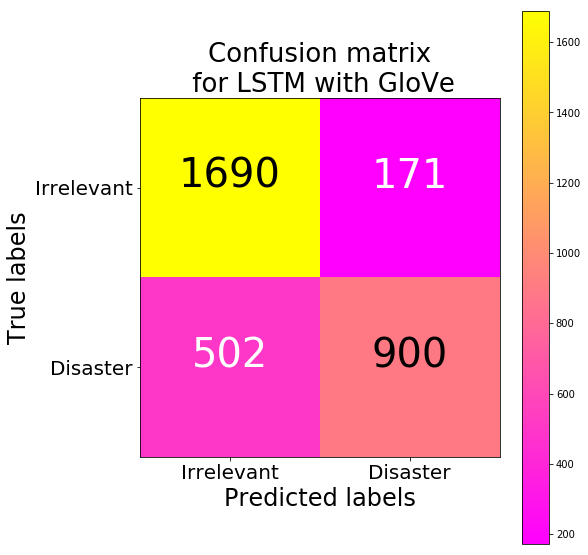

In [44]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.spring):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=26)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
   
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
   
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=24)
    plt.xlabel('Predicted labels', fontsize=24)

    return plt






def scores(y_test, y_predicted):  
    accuracy = accuracy_score(y_test, y_predicted)
    f1 = f1_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    precision = precision_score(y_test, y_predicted, pos_label = None, average = 'weighted')            
    recall = recall_score(y_test, y_predicted, pos_label = None, average = 'weighted')
    print("accuracy = %.4f, f1 = %.4f, precision = %.4f, recall = %.4f" % (accuracy, f1, precision, recall))
    return accuracy, f1, precision, recall


cm = confusion_matrix(correct_submission.target, sample_submission.target)
fig = plt.figure(figsize=(8, 8))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster'], normalize=False, title='Confusion matrix\n for LSTM with GloVe')
plt.show()


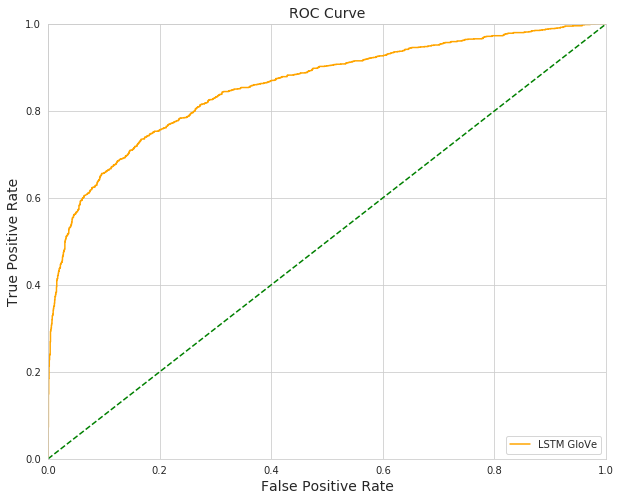

In [45]:
from sklearn.metrics import roc_curve
import seaborn as sns

# predict_proba gives the probabilities for the target (0 and 1 in our case) as a list (array).
# The number of probabilities for each row is equal to the number of categories in target variable (2 in our case).

probabilities_LSTM = model_2.predict_proba(X_test_tes_sequence)


# Using [:,1] gives us the probabilities of getting the output as 1

probability_of_ones_LSTM = probabilities_LSTM
#probability_of_ones_LSTM = probabilities_LSTM[:,1]
# probability_of_ones_LogisticRegression = probabilities_LogisticRegression[:,1]


# roc_curve returns:
# - false positive rates (FPrates), i.e., the false positive rate of predictions with score >= thresholds[i]
# - true positive rates (TPrates), i.e., the true positive rate of predictions with score >= thresholds[i]
# - thresholds

FPrates_LSTM, TPrates_LSTM, thresholds_LSTM = roc_curve(correct_submission.target, probability_of_ones_LSTM)

#FPrates_LSTM, TPrates_LSTM, thresholds_LSTM = roc_curve(y_test_1, probability_of_ones_LSTM)
# FPrates_LogisticRegression, TPrates_LogisticRegression, thresholds_LogisticRegression = roc_curve(y_test, probability_of_ones_LogisticRegression)



# plotting the ROC Curve to visualize all the methods

sns.set_style('whitegrid')
plt.figure(figsize = (10, 8))

plt.plot(FPrates_LSTM, TPrates_LSTM, label = 'LSTM GloVe', color = 'orange')
# plt.plot(FPrates_LogisticRegression, TPrates_LogisticRegression, label = 'Logistic Regression')


plt.plot([0, 1], [0, 1], color = 'green', linestyle = '--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC Curve', fontsize = 14)
plt.legend(loc = "lower right")
plt.show()


